# Customer Segmentation with RFM Analysis

In [1]:
#ilgili kütüphaneler
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install missingno
import missingno as msno


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.float_format", lambda x: "%.3f" %x)

In [3]:
df = pd.read_csv("D:/commerce_data.csv", encoding="latin-1")


In [4]:
#veri setine genel bakış
def check_df(dataframe, head=5):
    print("############# SHAPE #############")
    print(dataframe.shape)
    print("############# TYPES #############")
    print(dataframe.dtypes)
    print("############# HEAD #############")
    print(dataframe.head(5))
    print("############# TAİL #############")
    print(dataframe.tail(5))
    print("############# NA #############")
    print(dataframe.isnull().sum())
    print("############# QUANTİLES #############")
    print(dataframe.describe([0, 0.05, 0.5, 0.095, 0.99, 1]).T)
check_df(df)


############# SHAPE #############
(541909, 8)
############# TYPES #############
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
############# HEAD #############
  InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26      2.550   17850.000  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26      3.390   17850.000  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26      2.750   17850.000  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26      3.390   17850.000  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 

In [5]:
#Değişkenleri Yakalama
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]              

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and    
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]


    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 541909
Variables: 8
cat_cols: 0
num_cols: 3
cat_but_car: 5
num_but_cat: 0


count   541909.000
mean         9.552
std        218.081
min     -80995.000
5%           1.000
10%          1.000
20%          1.000
30%          2.000
40%          2.000
50%          3.000
60%          5.000
70%          8.000
80%         12.000
90%         24.000
95%         29.000
99%        100.000
max      80995.000
Name: Quantity, dtype: float64


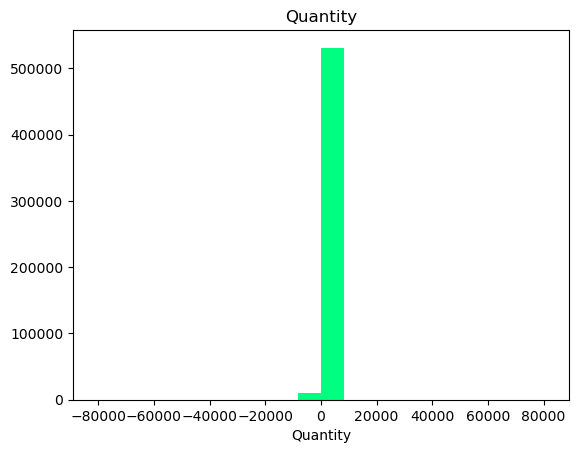

count   541909.000
mean         4.611
std         96.760
min     -11062.060
5%           0.420
10%          0.630
20%          0.850
30%          1.250
40%          1.650
50%          2.080
60%          2.550
70%          3.750
80%          4.950
90%          7.950
95%          9.950
99%         18.000
max      38970.000
Name: UnitPrice, dtype: float64


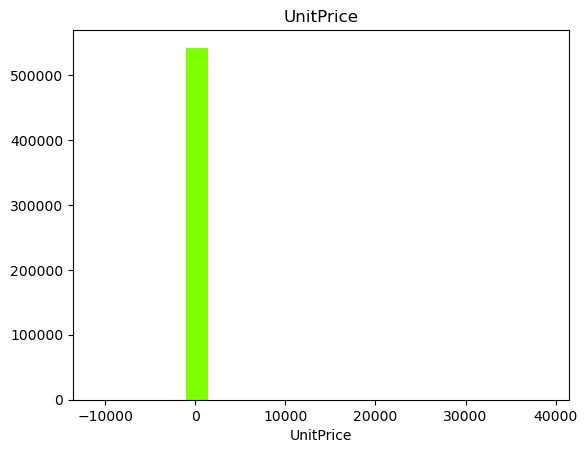

count   406829.000
mean     15287.691
std       1713.600
min      12346.000
5%       12626.000
10%      12876.000
20%      13536.000
30%      14159.000
40%      14659.000
50%      15152.000
60%      15805.000
70%      16493.000
80%      17095.000
90%      17719.000
95%      17905.000
99%      18212.000
max      18287.000
Name: CustomerID, dtype: float64


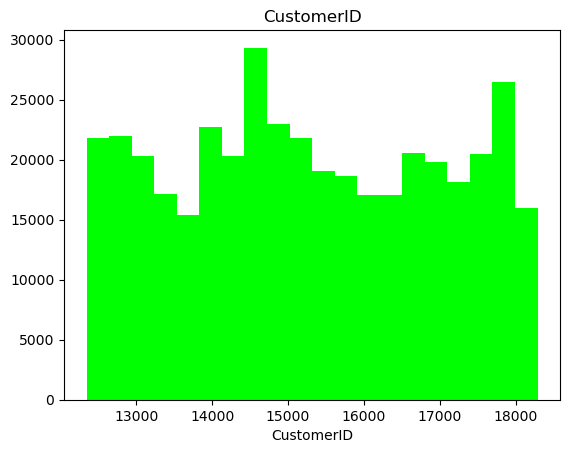

In [6]:
#numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff',
              '#ff8000', '#8000ff', '#0080ff', '#ff0080', '#80ff00', '#00ff80']
    np.random.shuffle(colors)
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        fig, ax = plt.subplots()
        ax.hist(dataframe[numerical_col], bins=20, color=colors[np.random.randint(0, len(colors))])
        ax.set_xlabel(numerical_col)
        ax.set_title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [7]:
#Eşsiz ürün-değer sayısı için:
df["Description"].nunique()


4223

In [8]:
#hangi üründen kaçar tane var (stok)?
df["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

In [9]:
#hangi üründen kaçar tane sipariş edilmiş?
df.groupby("Description").agg({"Quantity": "sum"}).head()

Quantity
Description                             
 4 PURPLE FLOCK DINNER CANDLES       144
 50'S CHRISTMAS GIFT BAG LARGE      1913
 DOLLY GIRL BEAKER                  2448
 I LOVE LONDON MINI BACKPACK         389
 I LOVE LONDON MINI RUCKSACK           1

In [10]:
#Quantityleri büyükten küçüğe sıralayalım.
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending = False).head()

Quantity
Description                                
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
JUMBO BAG RED RETROSPOT               47363
ASSORTED COLOUR BIRD ORNAMENT         36381
POPCORN HOLDER                        36334
PACK OF 72 RETROSPOT CAKE CASES       36039

In [11]:
#eşsiz invoice sayısı, toplamda kesilen fatura sayısı
df["InvoiceNo"].nunique()

25900

In [12]:
#Fatura başına toplam kaç para kazanılmıştır
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["TotalPrice"].head(5)

0   15.300
1   20.340
2   22.000
3   20.340
4   20.340
Name: TotalPrice, dtype: float64

In [13]:
#invoice (fatura) başına toplam kaç para ödendiğini öğrenmek için
df.groupby("InvoiceNo").agg({"TotalPrice" :"sum"}).head()

TotalPrice
InvoiceNo            
536365        139.120
536366         22.200
536367        278.730
536368         70.050
536369         17.850

In [14]:
#Ürünlerin ortalama fiyatları
df['AveragePrice'] = df.groupby('StockCode')['UnitPrice'].transform('mean')
df['AveragePrice'].head(5)

0   3.103
1   4.777
2   4.255
3   5.177
4   5.068
Name: AveragePrice, dtype: float64

In [15]:
#Fatura tarihinin ayı
df['InvoiceMonth'] = pd.to_datetime(df['InvoiceDate']).dt.month


In [16]:
#her ayda hangi üründen ne kadar satış yapıldı
monthly_sales = df.groupby(['InvoiceMonth', 'StockCode'])['Quantity'].sum().reset_index()
monthly_sales

InvoiceMonth     StockCode  Quantity
0                 1         10002       340
1                 1         10125       213
2                 1         10133       180
3                 1         10135       613
4                 1         11001        33
5                 1         15034       177
6                 1         15036       377
7                 1         15039        54
8                 1        15044A        20
9                 1        15044B        24
10                1        15044C         7
11                1        15044D        33
12                1       15056BL       193
13                1        15056N       138
14                1        15056P        15
15                1       15056bl         3
16                1        15056n         2
17                1        15056p         2
18                1        15058B         3
19                1        15060B        45
20                1         16011       191
21                1         16012        96
22                1         16014        10
23                1         16015        20
24                1         16016        40
25                1         16033       120
26                1         16048         1
27                1         16052        27
28                1        16156L        50
29                1        16156S       350
30                1        16161P       451
31                1        16161U       300
32                1        16162L         1
33                1        16168M        31
34                1        16169K       100
35                1        16169M        50
36                1        16206B         5
37                1        16207B         3
38                1         16219        14
39                1         16225       138
40                1         16235       219
41                1         16236       122
42                1         16237       393
43                1         16238        58
44                1        16258A        58
45                1         17003      3181
46                1        17011A       -61
47                1        17011F         6
48                1        17012A        16
49                1        17012B        25
50                1        17012C        10
51                1        17012D        14
52                1        17012F        12
53                1        17013D       108
54                1         17021       606
55                1        17028J         6
56                1         17038       108
57                1        17084A        50
58                1        17084J        50
59                1        17084N       117
60                1        17084P        56
61                1        17090A         6
62                1        17091A         7
63                1        17091J       116
64                1         17096       199
65                1        17107D         6
66                1        17129F        14
67                1        17164B        17
68                1        17165D         8
69                1         17174         1
70                1         18007        29
71                1        18094C         2
72                1        18097C        69
73                1        18098C        49
74                1         20615        30
75                1         20616        10
76                1         20617        12
77                1         20618        22
78                1         20619        41
79                1         20622        42
80                1         20652        82
81                1         20653        17
82                1         20654        25
83                1         20655        41
84                1         20657         1
85                1         20658        38
86                1         20659        21
87                1         20662        12
88                1         20663        10
89                1         20665        24
90 

In [17]:
#Her ürün için toplam satış miktarı
total_sales_by_product = df.groupby('StockCode')['Quantity'].sum().reset_index()
total_sales_by_product.rename(columns={'Quantity': 'TotalSalesByProduct'}, inplace=True)
df = df.merge(total_sales_by_product, on='StockCode', how='left')

In [18]:
#her ay ne kadar para kazanıldı
monthly_earnings = df.groupby('InvoiceMonth')['TotalPrice'].sum().sort_values(ascending=True)
monthly_earnings

InvoiceMonth
4     493207.121
2     498062.650
1     560000.260
7     681300.111
8     682680.510
3     683267.080
6     691123.120
5     723333.510
9    1019687.622
10   1070704.670
12   1182625.030
11   1461756.250
Name: TotalPrice, dtype: float64

In [19]:
# müşterilerin toplam harcamalara göre sıralaması
df['CustomerSpendingRank'] = df.groupby('CustomerID')['TotalPrice'].rank(ascending=False)
df['CustomerSpendingRank'].head(10)

0   162.000
1    92.500
2    66.500
3    92.500
4    92.500
5   143.000
6    55.500
7   212.500
8   212.500
9     2.000
Name: CustomerSpendingRank, dtype: float64

In [20]:
#en çok para kazandıran ülkeler
df.groupby('Country').agg({'TotalPrice':'sum'}).sort_values('TotalPrice', ascending = False).head(3)

TotalPrice
Country                   
United Kingdom 8187806.364
Netherlands     284661.540
EIRE            263276.820

In [21]:
#iade edilen faturaları veri setinden çıkaralım
df = df[~df["InvoiceNo"].str.contains("C", na=False)]

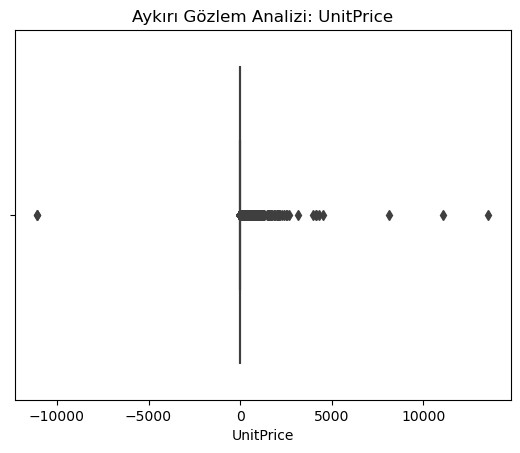

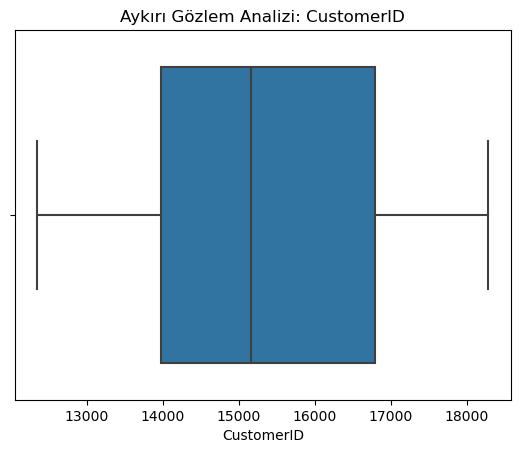

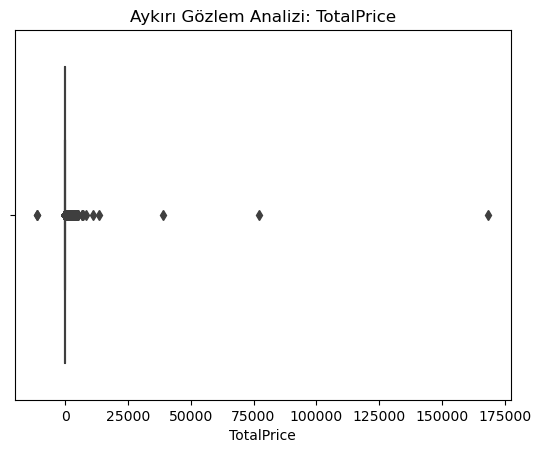

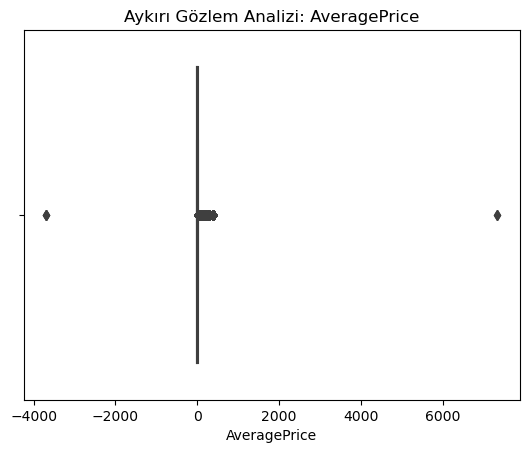

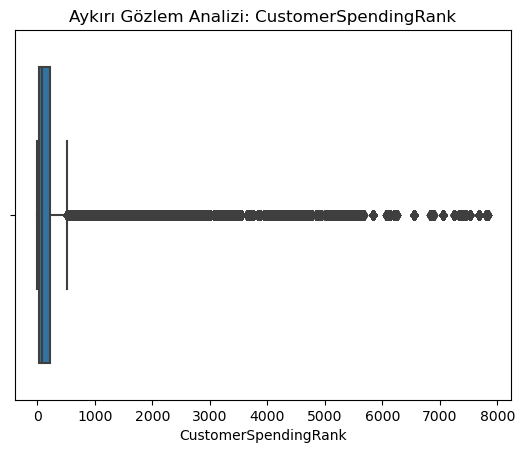

In [22]:
#Aykırı Gözlem Analizi
def outlier_analysis(df):
    for column in df.columns:
        if df[column].dtype in [int, float]: 
            sns.boxplot(x=df[column])
            plt.title(f"Aykırı Gözlem Analizi: {column}")
            plt.show()

outlier_analysis(df)

In [25]:
def outlier_thresholds(dataframe,col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile( q1 )
  quartile3 = dataframe[col_name].quantile( q3 )
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5 * interquantile_range
  low_limit = quartile1 - 1.5 * interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True  
    else:
        return False 
    
for col in num_cols:
    print(col, check_outlier(df, col))

Quantity False
UnitPrice False
CustomerID False


In [26]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

In [27]:
for col in num_cols:
    print(col, check_outlier(df, col))

Quantity False
UnitPrice False
CustomerID False


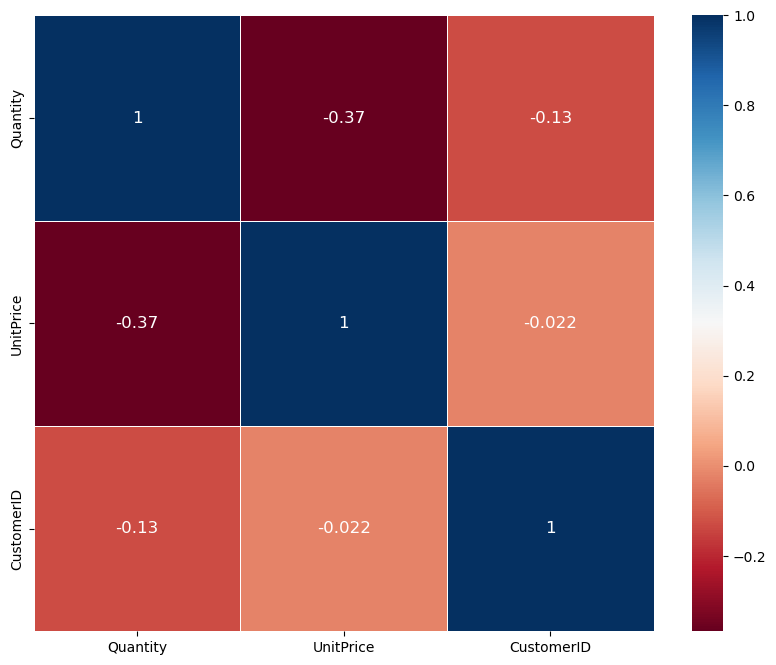

In [28]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
correlation_matrix(df, num_cols)

In [29]:
# Missing Values (Eksik Değerler)
df.isnull().values.any()

True

In [30]:
df.notnull().sum()


InvoiceNo               532621
StockCode               532621
Description             531167
Quantity                532621
InvoiceDate             532621
UnitPrice               532621
CustomerID              397924
Country                 532621
TotalPrice              532621
AveragePrice            532621
InvoiceMonth            532621
TotalSalesByProduct     532621
CustomerSpendingRank    397924
dtype: int64

In [31]:
df.isnull().sum()

InvoiceNo                    0
StockCode                    0
Description               1454
Quantity                     0
InvoiceDate                  0
UnitPrice                    0
CustomerID              134697
Country                      0
TotalPrice                   0
AveragePrice                 0
InvoiceMonth                 0
TotalSalesByProduct          0
CustomerSpendingRank    134697
dtype: int64

In [32]:
#hangi değişkende kaç tane 0 var.
df.eq(0).sum()

InvoiceNo                  0
StockCode                  0
Description                0
Quantity                   0
InvoiceDate                0
UnitPrice               2515
CustomerID                 0
Country                    0
TotalPrice              2515
AveragePrice             134
InvoiceMonth               0
TotalSalesByProduct       56
CustomerSpendingRank       0
dtype: int64

In [33]:
columns_to_check = ['TotalSalesByProduct', 'TotalPrice', 'AveragePrice', 'UnitPrice']
for column in columns_to_check:
    df = df[df[column] > 0]

In [34]:
df.eq(0).sum()

InvoiceNo               0
StockCode               0
Description             0
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID              0
Country                 0
TotalPrice              0
AveragePrice            0
InvoiceMonth            0
TotalSalesByProduct     0
CustomerSpendingRank    0
dtype: int64

In [35]:
#na_cols=eksik değerlerin olduğu kolonlar
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
na_cols

['CustomerID', 'CustomerSpendingRank']

In [36]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    #eksik değer sayısı için;
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    #eksik değer oranı için;
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    #axis=1 ,sütunlara göre birleştirme işlemi yapmak istiyorum.
    #np.round(..) virgülden sonraki basamakla ilgili bir ayarlama yapılmış.
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

                      n_miss  ratio
CustomerID            131305 24.950
CustomerSpendingRank  131305 24.950


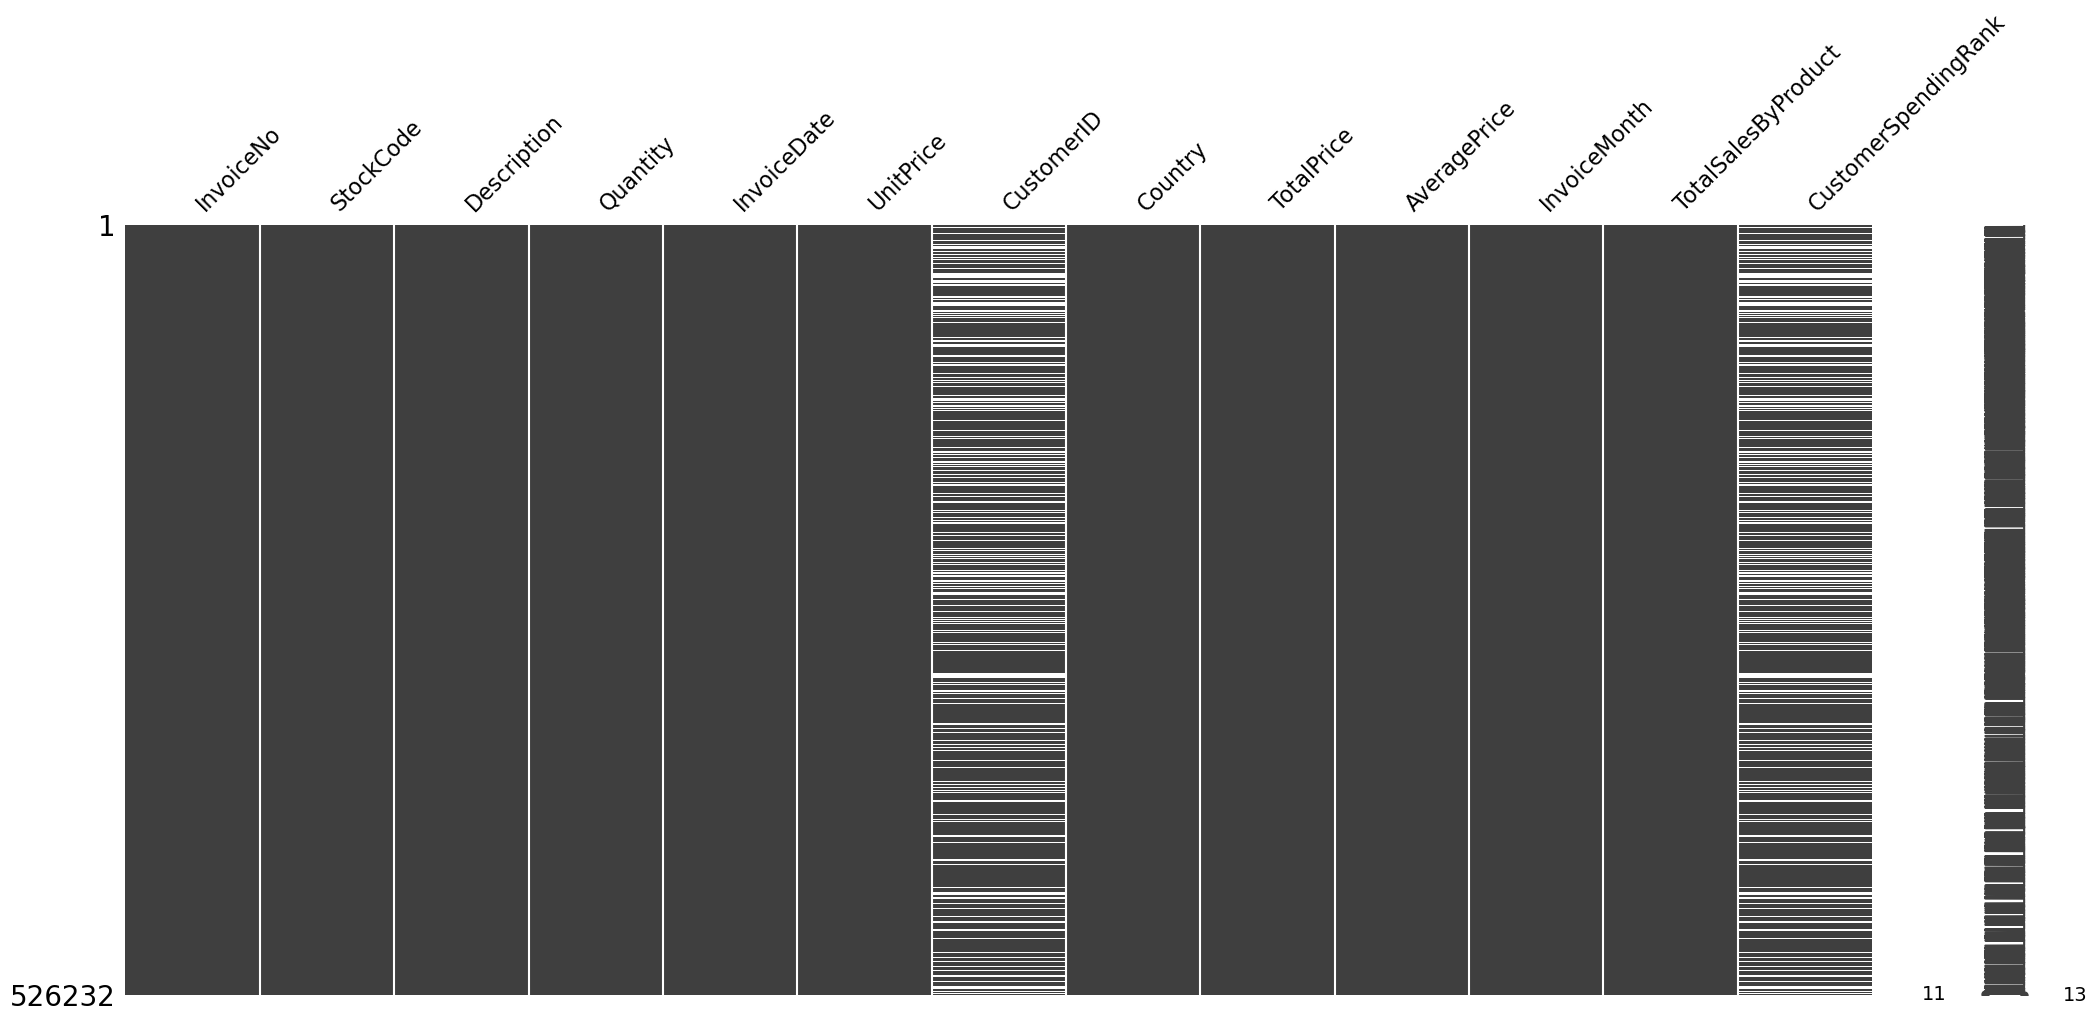

In [37]:
msno.matrix(df)
plt.show()

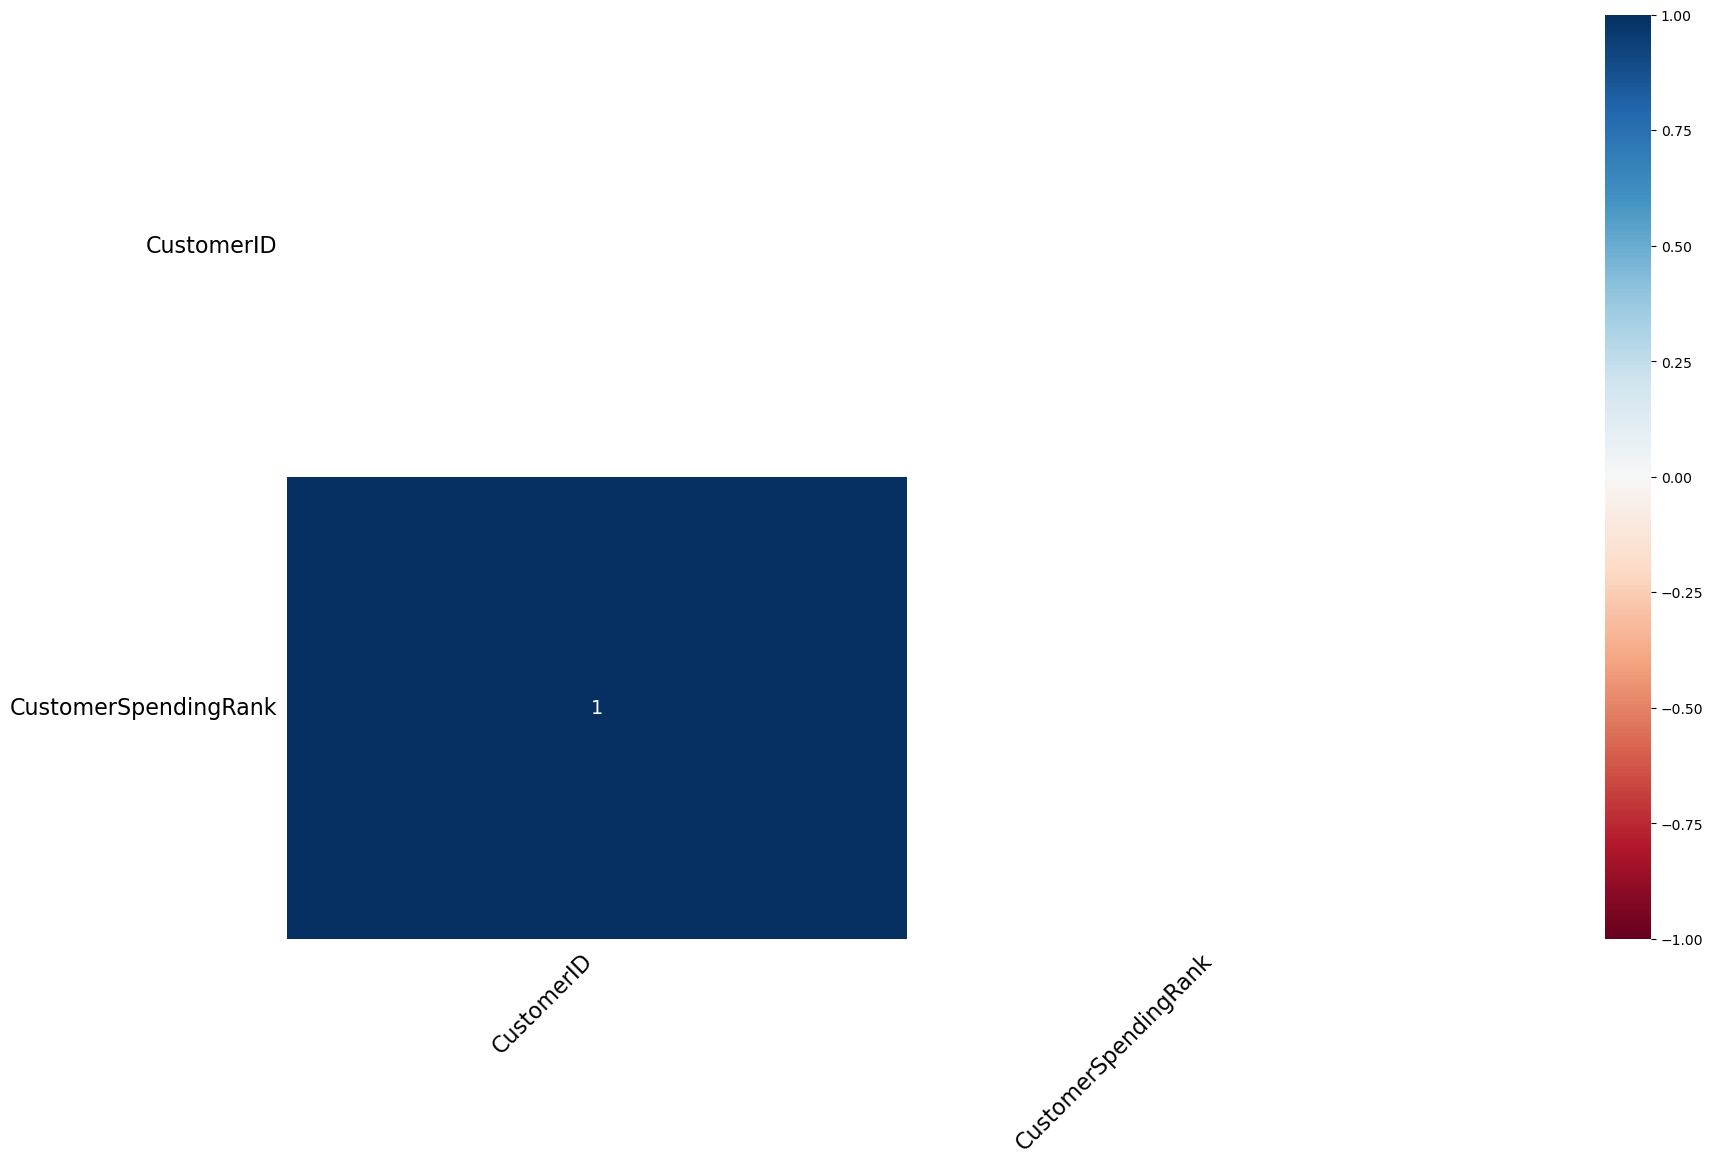

In [38]:
msno.heatmap(df)
plt.show()

In [39]:
#Eksik Değer Problemini Çözme

df.dropna(inplace=True)
df.dropna(axis=1, inplace=True)


In [40]:
#df.isnull().values.any()
df.isnull().sum()


InvoiceNo               0
StockCode               0
Description             0
Quantity                0
InvoiceDate             0
UnitPrice               0
CustomerID              0
Country                 0
TotalPrice              0
AveragePrice            0
InvoiceMonth            0
TotalSalesByProduct     0
CustomerSpendingRank    0
dtype: int64

In [41]:
## RFM (Recency, Frequency, Monetary)

In [44]:
df.head(5)

InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  AveragePrice  InvoiceMonth  TotalSalesByProduct  CustomerSpendingRank
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER     6.000  12/1/2010 8:26      2.550   17850.000  United Kingdom      15.300         3.103            12                38830               162.000
1    536365     71053                  WHITE METAL LANTERN     6.000  12/1/2010 8:26      3.390   17850.000  United Kingdom      20.340         4.777            12                 1911                92.500
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER     8.000  12/1/2010 8:26      2.750   17850.000  United Kingdom      22.000         4.255            12                 1422                66.500
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE     6.000  12/1/2010 8:26      3.390   17850.000  United Kingdom      20.340         5.177            12                 3589                92.500
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.     6.000  12/1/2010 8:26      3.390   17850.000  United Kingdom      20.340         5.068            12                 4660                92.500

In [45]:
# veri seti içinde işlem yapılan son tarih
df["InvoiceDate"].max()

'9/9/2011 9:52'

In [46]:
#analiz yapılan tarih için (year, month, day)
today_date = dt.datetime(2011, 9, 11)

In [47]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [48]:
rfm = df.groupby("CustomerID").agg({"InvoiceDate": lambda date: (today_date - date.max()).days,
                                      "InvoiceNo": lambda num: num.nunique(),
                                      "TotalPrice": lambda TotalPrice: TotalPrice.sum()
                                    })
rfm.head()

InvoiceDate  InvoiceNo  TotalPrice
CustomerID                                    
12346.000           235          1   77183.600
12347.000           -88          7    4310.000
12348.000           -15          4    1797.240
12349.000           -72          1    1742.700
12350.000           220          1     334.400

In [49]:
rfm.columns = ["recency", "frequency", "monetary"]

In [50]:
rfm.describe().T

count     mean      std     min     25%     50%      75%        max
recency   4336.000    2.100  100.002 -90.000 -73.000 -40.000   52.000    283.000
frequency 4336.000    4.268    7.693   1.000   1.000   2.000    5.000    209.000
monetary  4336.000 2003.082 8584.033   1.000 305.600 667.120 1646.645 279806.120

In [51]:
rfm

recency  frequency   monetary
CustomerID                               
12346.000       235          1  77183.600
12347.000       -88          7   4310.000
12348.000       -15          4   1797.240
12349.000       -72          1   1742.700
12350.000       220          1    334.400
12352.000       -54          8   2491.190
12353.000       114          1     89.000
12354.000       142          1   1079.400
12355.000       124          1    459.400
12356.000       -68          3   2811.430
12357.000       -57          1   6207.670
12358.000       -89          2   1168.060
12359.000       -33          4   6342.880
12360.000       -38          3   2647.210
12361.000       197          1    189.900
12362.000       -87         10   5191.430
12363.000        19          2    552.000
12364.000       -83          4   1313.100
12365.000       201          2    624.380
12367.000       -86          1    168.900
12370.000       -39          4   3468.410
12371.000       -46          2   1784.460
12372.000       -19          3   1298.040
12373.000       221          1    364.600
12374.000       -65          1    742.930
12375.000       -80          2    457.500
12377.000       225          2   1628.120
12378.000        39          1   3991.220
12379.000        -9          2    852.240
12380.000       -69          4   2724.810
12381.000       -86          5   1845.310
12383.000        94          5   1850.560
12384.000       -62          2    585.270
12386.000       247          2    401.900
12388.000       -75          6   2780.660
12390.000       -11          1    549.840
12391.000       -69          1    460.890
12393.000       -18          4   1567.750
12394.000       -27          2   1272.480
12395.000       -71         12   2978.680
12397.000       -55          2   2395.050
12398.000       -45          1   1605.960
12399.000        29          4   1108.650
12401.000       213          1     84.300
12402.000       233          1    225.600
12403.000       -41          1    427.700
12405.000        58          1   1641.090
12406.000       -68          2   3370.750
12407.000       -41          5   1693.270
12408.000       -58          5   2799.450
12409.000       -12          3  11072.670
12410.000       218          2    693.330
12412.000       -16          3   1226.880
12413.000       -24          3    728.400
12414.000       127          3    483.210
12415.000       -66         21 123901.730
12417.000       -87          9   3635.150
12418.000        22          1    653.730
12420.000       -27          1    600.390
12421.000       -75          4    782.290
12422.000         5          3    803.560
12423.000       -90          8   1859.310
12424.000        72          2   1746.110
12425.000       -12          1    777.200
12426.000       104          1    582.730
12427.000       -69          3    765.320
12428.000       -65          9   7936.660
12429.000       -81          4   3720.400
12430.000       -47          1    256.400
12431.000       -55         15   6388.450
12432.000       -48          5   4934.970
12433.000       -90          7  13375.870
12434.000        -6          2    806.140
12435.000       -11          2   7829.890
12436.000         9          1    509.010
12437.000       -89         18   4951.410
12438.000       -76          2   2892.000
12441.000       276          1    150.300
12442.000       -87          1    172.060
12444.000       -69          5   4988.460
12445.000       -68          1    133.400
12446.000       -33          1   1002.310
12447.000       153          1    476.490
12448.000       -46          1    449.450
12449.000       -68          4   4067.290
12450.000        66          2    197.880
12451.000       -80          5   9020.670
12452.000       -74          2    430.570
12453.000        44          1    707.090
12454.000       -34          1   3269.620
12455.000       -17          6   2466.860
12456.000       -46          3   3181.040
12457.000       -24          7   2363.230
12458.000       -19   

### RFM SKORLARININ HESAPLANMASI

In [52]:
rfm["recency_score"] = pd.qcut(rfm["recency"], 5, labels=[5,4,3,2,1])
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1,2,3,4,5])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method = "first"), 5, labels=[1,2,3,4,5])

In [53]:
rfm.head()

recency  frequency  monetary recency_score monetary_score frequency_score
CustomerID                                                                           
12346.000       235          1 77183.600             1              5               1
12347.000       -88          7  4310.000             5              5               5
12348.000       -15          4  1797.240             2              4               4
12349.000       -72          1  1742.700             4              4               1
12350.000       220          1   334.400             1              2               1

In [54]:
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) +
                    rfm["frequency_score"].astype(str))
rfm.head()

recency  frequency  monetary recency_score monetary_score frequency_score RFM_SCORE
CustomerID                                                                                     
12346.000       235          1 77183.600             1              5               1        11
12347.000       -88          7  4310.000             5              5               5        55
12348.000       -15          4  1797.240             2              4               4        24
12349.000       -72          1  1742.700             4              4               1        41
12350.000       220          1   334.400             1              2               1        11

In [55]:
rfm.describe().T

count     mean      std     min     25%     50%      75%        max
recency   4336.000    2.100  100.002 -90.000 -73.000 -40.000   52.000    283.000
frequency 4336.000    4.268    7.693   1.000   1.000   2.000    5.000    209.000
monetary  4336.000 2003.082 8584.033   1.000 305.600 667.120 1646.645 279806.120

In [56]:
#RFM İSİMLENDİRİLMESİ
seg_map = {
    r"[1-2][1-2]" : "hibernating",
    r"[1-2][3-4]": "at_Risk",
    #birinci elemanında 1 ya da 2, ikinci elmanında 5 görürsen cant_loose isimlendirmesi yap
    r"[1-2]5": "cant_loose",
    r"3[1-2]": "about_to_sleep",
    #birinci elemanında 3, ikinci elemanında 3 görürsen neeed_attention isimlendirmesi yap.
    r"33": "need_attention",
    r"[3-4][4-5]": "loyal_customers",
    r"41": "promising",
    r"51": "new_customers",
    r"[4-5][2-3]": "potential_loyalists",
    r"5[4-5]": "champions",
}

In [57]:
rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)
rfm.head()

recency  frequency  monetary recency_score monetary_score frequency_score RFM_SCORE      segment
CustomerID                                                                                                  
12346.000       235          1 77183.600             1              5               1        11  hibernating
12347.000       -88          7  4310.000             5              5               5        55    champions
12348.000       -15          4  1797.240             2              4               4        24      at_Risk
12349.000       -72          1  1742.700             4              4               1        41    promising
12350.000       220          1   334.400             1              2               1        11  hibernating

In [59]:
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency       frequency       monetary      
                       mean count      mean count     mean count
segment                                                         
about_to_sleep      -37.700   353     1.159   353  467.275   353
at_Risk              63.017   594     2.872   594 1082.714   594
cant_loose           42.935    62     8.403    62 2793.181    62
champions           -84.338   654    12.272   654 6699.949   654
hibernating         126.572  1070     1.101  1070  482.699  1070
loyal_customers     -56.895   798     6.421   798 2836.660   798
need_attention      -38.532   186     2.328   186  896.242   186
new_customers       -82.766    47     1.000    47  366.819    47
potential_loyalists -73.567   483     2.010   483  687.482   483
promising           -67.011    89     1.000    89  294.396    89

In [60]:
rfm.index = rfm.index.astype(int)

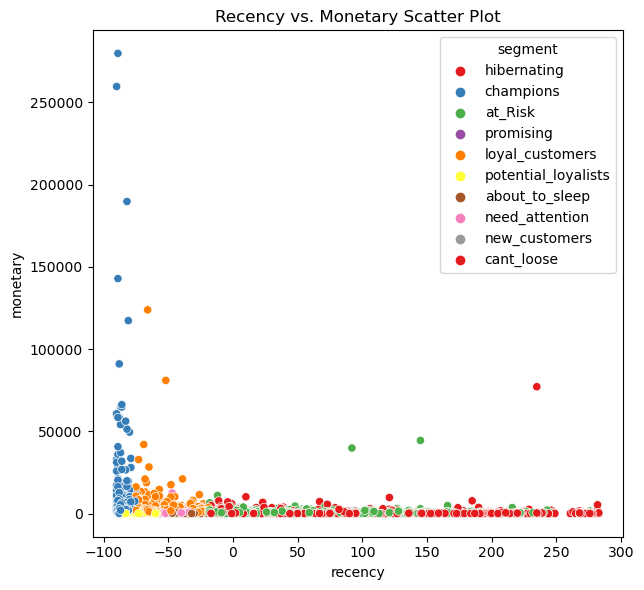

In [61]:
#Recency vs. Monetary Scatter Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=rfm, x="recency", y="monetary", hue="segment", palette="Set1")
plt.title("Recency vs. Monetary Scatter Plot")
plt.tight_layout()
plt.show()



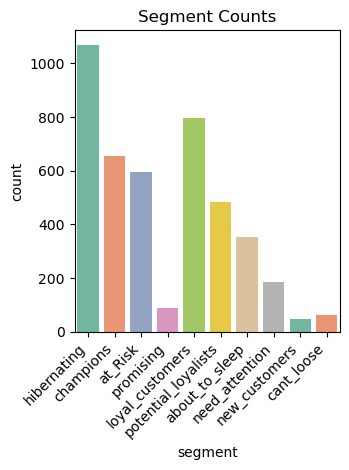

In [62]:
 #Segment Sayıları
plt.subplot(1, 2, 2)
sns.countplot(data=rfm, x="segment", palette="Set2")
plt.title("Segment Counts")
plt.xticks(rotation=45, ha="right")
    
plt.tight_layout()
plt.show()


In [64]:
import plotly.express as px
#Recency
fig_recency = px.histogram(rfm, x="recency", nbins=20, title="Recency")
fig_recency.show()

In [65]:
# Frequency
fig_frequency = px.histogram(rfm, x="frequency", nbins=20, title="Frequency")
fig_frequency.show()

In [66]:
# Monetary
fig_monetary = px.histogram(rfm, x="monetary", nbins=20, title="Monetary")
fig_monetary.show()

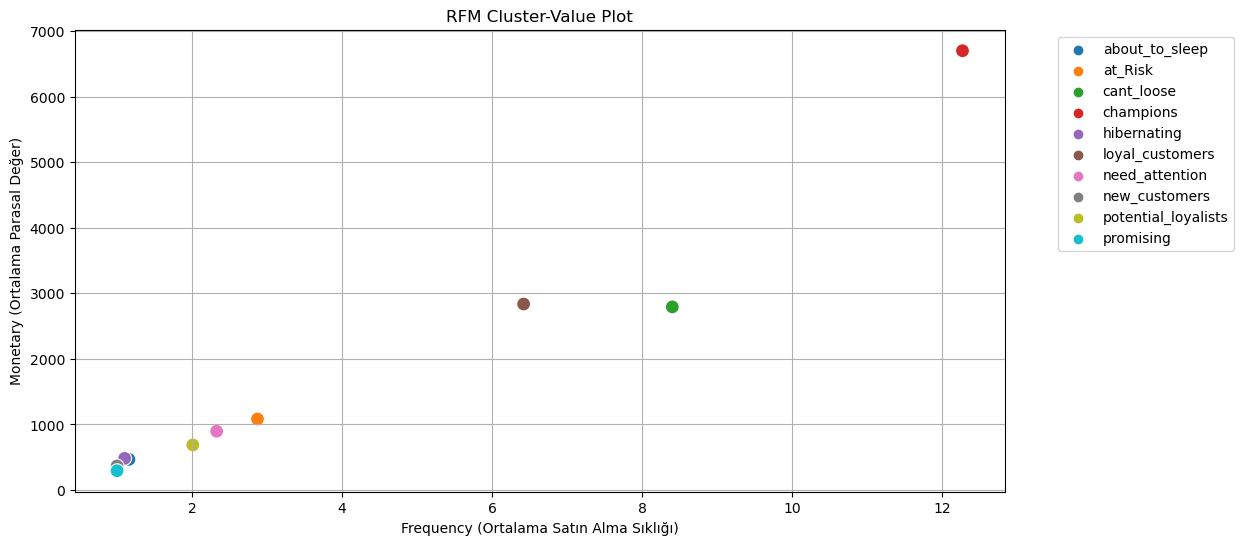

In [67]:
rfm_segment_value = rfm.groupby("segment").agg({"monetary": "mean", "frequency": "mean"}).reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm_segment_value, x="frequency", y="monetary", hue="segment", s=100)
plt.xlabel("Frequency (Ortalama Satın Alma Sıklığı)")
plt.ylabel("Monetary (Ortalama Parasal Değer)")
plt.title("RFM Cluster-Value Plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

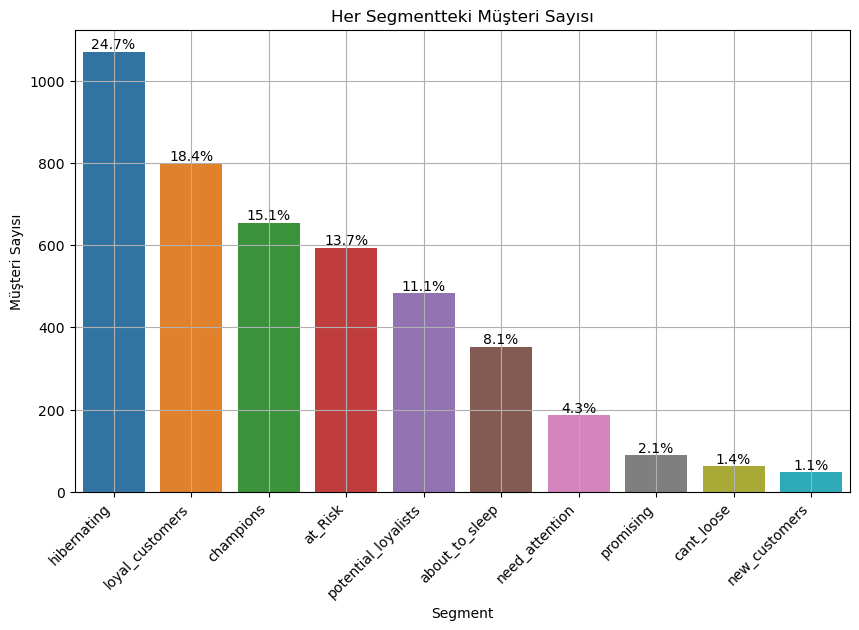

In [68]:
rfm_segment_counts = rfm["segment"].value_counts().reset_index()
rfm_segment_counts.columns = ["segment", "customer_count"]
total_customers = rfm_segment_counts["customer_count"].sum()
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=rfm_segment_counts, x="segment", y="customer_count")
plt.xlabel("Segment")
plt.ylabel("Müşteri Sayısı")
plt.title("Her Segmentteki Müşteri Sayısı")
plt.xticks(rotation=45, ha="right")
plt.grid(True)

for index, row in rfm_segment_counts.iterrows():
    percentage = (row["customer_count"] / total_customers) * 100
    plt.text(index, row["customer_count"], f"{percentage:.1f}%", ha="center", va="bottom")

plt.show()

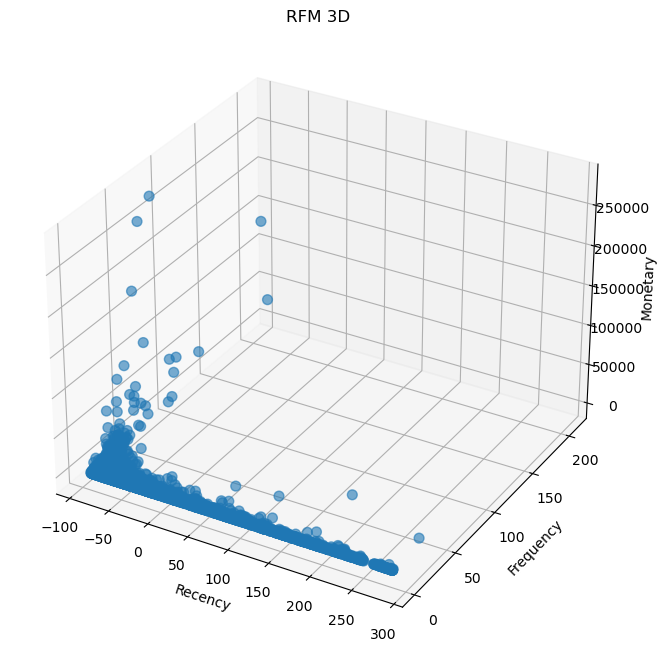

In [69]:
from mpl_toolkits.mplot3d import Axes3D

recency = rfm["recency"]
frequency = rfm["frequency"]
monetary = rfm["monetary"]

# 3D grafik için
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(recency, frequency, monetary, s=50, alpha=0.6)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

plt.title("RFM 3D")

plt.show()

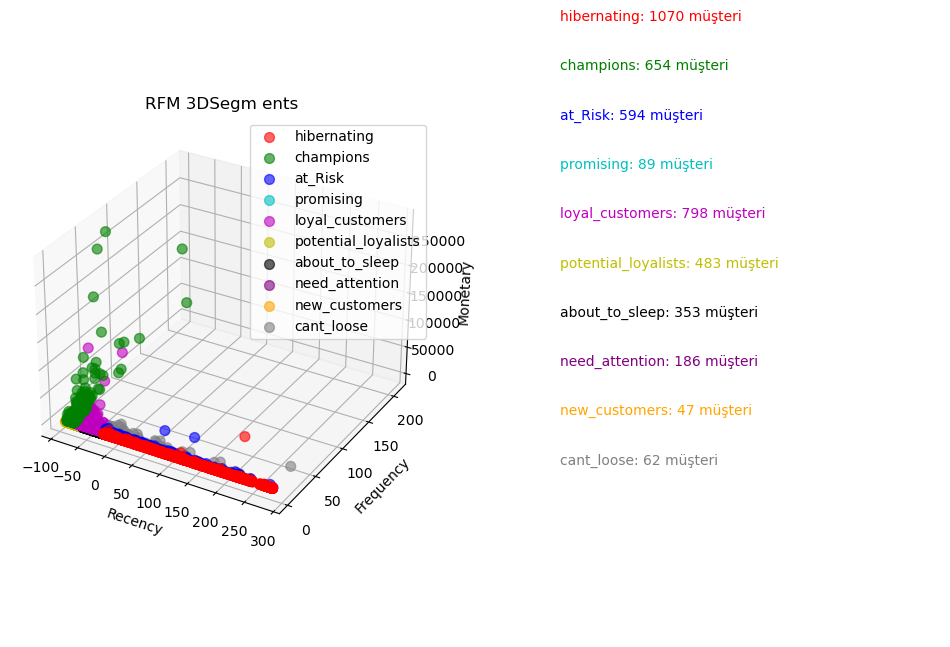

In [70]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121, projection="3d")  
ax_legend = fig.add_subplot(122)  

# segmentler
segments = rfm["segment"].unique()
colors = ["r", "g", "b", "c", "m", "y", "k", "purple", "orange", "gray"]

for i, segment in enumerate(segments):
    segment_data = rfm[rfm["segment"] == segment]
    ax.scatter(segment_data["recency"], segment_data["frequency"], segment_data["monetary"],
               s=50, alpha=0.6, c=colors[i], label=segment)
    # Segment açıklamaları
    ax_legend.text(0.1, 1 - (i * 0.08), f"{segment}: {segment_data.shape[0]} müşteri",
                   fontsize=10, color=colors[i], transform=ax_legend.transAxes)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

ax.set_title("RFM 3DSegm ents")
ax.legend(loc="upper right")

ax_legend.axis("off")

plt.show()

In [71]:
#yeni bir df oluştur (içine segmentlere ayrılan müşteriler atanacak)
new_df =pd.DataFrame()

new_df["new_customer_id"] = rfm[rfm["segment"] == "new_customers"].index
new_df["new_customer_id"] = new_df["new_customer_id"].astype(int)
new_df.to_csv("new_customers.csv")